<a href="https://www.kaggle.com/code/ryanlliu/baseline-pytorch-lightning?scriptVersionId=163166963" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Recap: EDA
- 78 Video:
  - 6224 frame images
  - 6224 mask images
  - 6224 mask enhance images
- The processed size is 1295x1026
- Frame label count: (6, 3743), (5, 1136), (3, 1022), (4, 323)
  - Label 3-None, 4-OnlySP, 5-OnlyHead, 6-SP+Head in framelabel.csv

In [1]:
!pip install -q watermark lightning

In [2]:
%load_ext watermark
%watermark -p torch,tensorboard,lightning,torchmetrics --conda

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


torch       : 2.0.0
tensorboard : 2.13.0
lightning   : 2.2.0.post0
torchmetrics: 1.2.1

conda environment: n/a



In [3]:
import random

from PIL import Image
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import lightning as L
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger

L.pytorch.seed_everything(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INFO: Seed set to 123


# Dataset/Dataloader

#### Organize datamodule with Lightning (soon) 

In [4]:
# import os
# from sklearn.model_selection import train_test_split
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms as T

# dataset_path = '/kaggle/input/jnu-ifm-for-segment-pubic-symphysis-fetal-head' + '/dataset'

# class FetalHeadDataModule(L.LightningDataModule):
#     def __init__(self, data_dir=dataset_path, mask_dir='mask', batch_size=8):
#         super().__init__()
#         self.data_dir = data_dir
#         self.mask_dir = mask_dir
#         self.batch_size = batch_size

#     def setup(self, stage: str):
#         self.mnist_test = datasets.MNIST(
#             self.data_dir, transform=transforms.ToTensor(), train=False
#         )
#         self.mnist_predict = datasets.MNIST(
#             self.data_dir, transform=transforms.ToTensor(), train=False
#         )
#         mnist_full = datasets.MNIST(
#             self.data_dir, transform=transforms.ToTensor(), train=True
#         )
#         self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000], generator=torch.Generator().manual_seed(42))

#     def train_dataloader(self):
#         return DataLoader(
#             self.mnist_train, batch_size=self.batch_size, shuffle=True, drop_last=True
#         )

#     def val_dataloader(self):
#         return DataLoader(self.mnist_val, batch_size=self.batch_size, shuffle=False)

#     def test_dataloader(self):
#         return DataLoader(self.mnist_test, batch_size=self.batch_size, shuffle=False)

#     def predict_dataloader(self):
#         return DataLoader(self.mnist_predict, batch_size=self.batch_size, shuffle=False)

In [5]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
b_sz = 8 # batch size

# define SEGMENTATION dataset class
class SegmentationDataset(Dataset):
    def __init__(self, dataset_path, mask_dir, imgs, masks, transform=None):
        self.imgs = imgs
        self.masks = masks
        self.transform = transform
        self.dataset_path = dataset_path
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = f'{self.dataset_path}/image/{img_name}'
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        mask_name = self.masks[idx]
        mask_path = f'{self.dataset_path}/{mask_dir}/{mask_name}'
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # read mask in grayscale
        
        # loss func: crossentropy just accept: 0, 1, 2, ... like indices
        mask[mask == 7] = 1 # convert mask value 7(SP) -> 1
        mask[mask == 8] = 2 # convert mask value 8(head) -> 2
        
        mask = Image.fromarray(mask)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        # convert to long tensor
        # and .squeeze() > removes redundant dimensions (1, rz, rz) > (rz, rz)
        # * 255 to avoid = 0 (due to long()), since being scaling [0, 1] of ToTensor()
        mask = (mask * 255).long().squeeze() 

        return image, mask
    
t_test = T.Compose([
        T.CenterCrop((1024, 1024)),
        T.Resize(size=(128, 128), interpolation=T.InterpolationMode.NEAREST),
        T.ToTensor(),
])

t_train = T.Compose([
        T.CenterCrop((1024, 1024)),
        T.Resize(size=(128, 128), interpolation=T.InterpolationMode.NEAREST),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=20),
        T.ToTensor(),
        T.RandomErasing(p=0.2),
])


def get_dataset_loaders(dataset_path, mask_dir):
    '''
    input: 
        - dataset_path,
        - mask_dir: subdir in dataset_path i.e 'mask' or 'enhance_mask'
    output:
        - train_loader, val_loader, test_loader
    '''
    ## GET IMAGE AND MASK PATHS
    img_paths = os.listdir(f'{dataset_path}/image')
    mask_paths = os.listdir(f'{dataset_path}/{mask_dir}')
    
    imgs = [img.replace("_mask", "") for img in mask_paths] # Mapping 1-1 between mask and image
    
    ## TEST-TRAIN SPLITTING ratio 9(9-1)-1
    train_img, test_img, train_mask, test_mask = train_test_split(imgs,
                                                                  mask_paths,
                                                                  test_size = 0.1,
                                                                  random_state=123)
    train_img, val_img, train_mask, val_mask = train_test_split(train_img,
                                                                train_mask,
                                                                test_size = 0.1,
                                                                random_state=123)
    
    ## DEFINE DATASET
    train_set = SegmentationDataset(
        dataset_path,
        mask_dir,
        train_img,
        train_mask,
        transform=t_train)
    val_set = SegmentationDataset(
        dataset_path,
        mask_dir,
        val_img,
        val_mask,
        transform=t_test)
    test_set = SegmentationDataset(
        dataset_path,
        mask_dir,
        test_img,
        test_mask,
        transform=t_test)
    
    ## DEFINE DATALOADER
    train_loader = DataLoader(dataset=train_set, batch_size=b_sz, shuffle=True, num_workers=3)
    val_loader = DataLoader(dataset=val_set, batch_size=b_sz, shuffle=False, num_workers=3)
    test_loader = DataLoader(dataset=test_set, batch_size=b_sz, shuffle=True, num_workers=3)

    return train_loader, val_loader, test_loader

Test dataloader

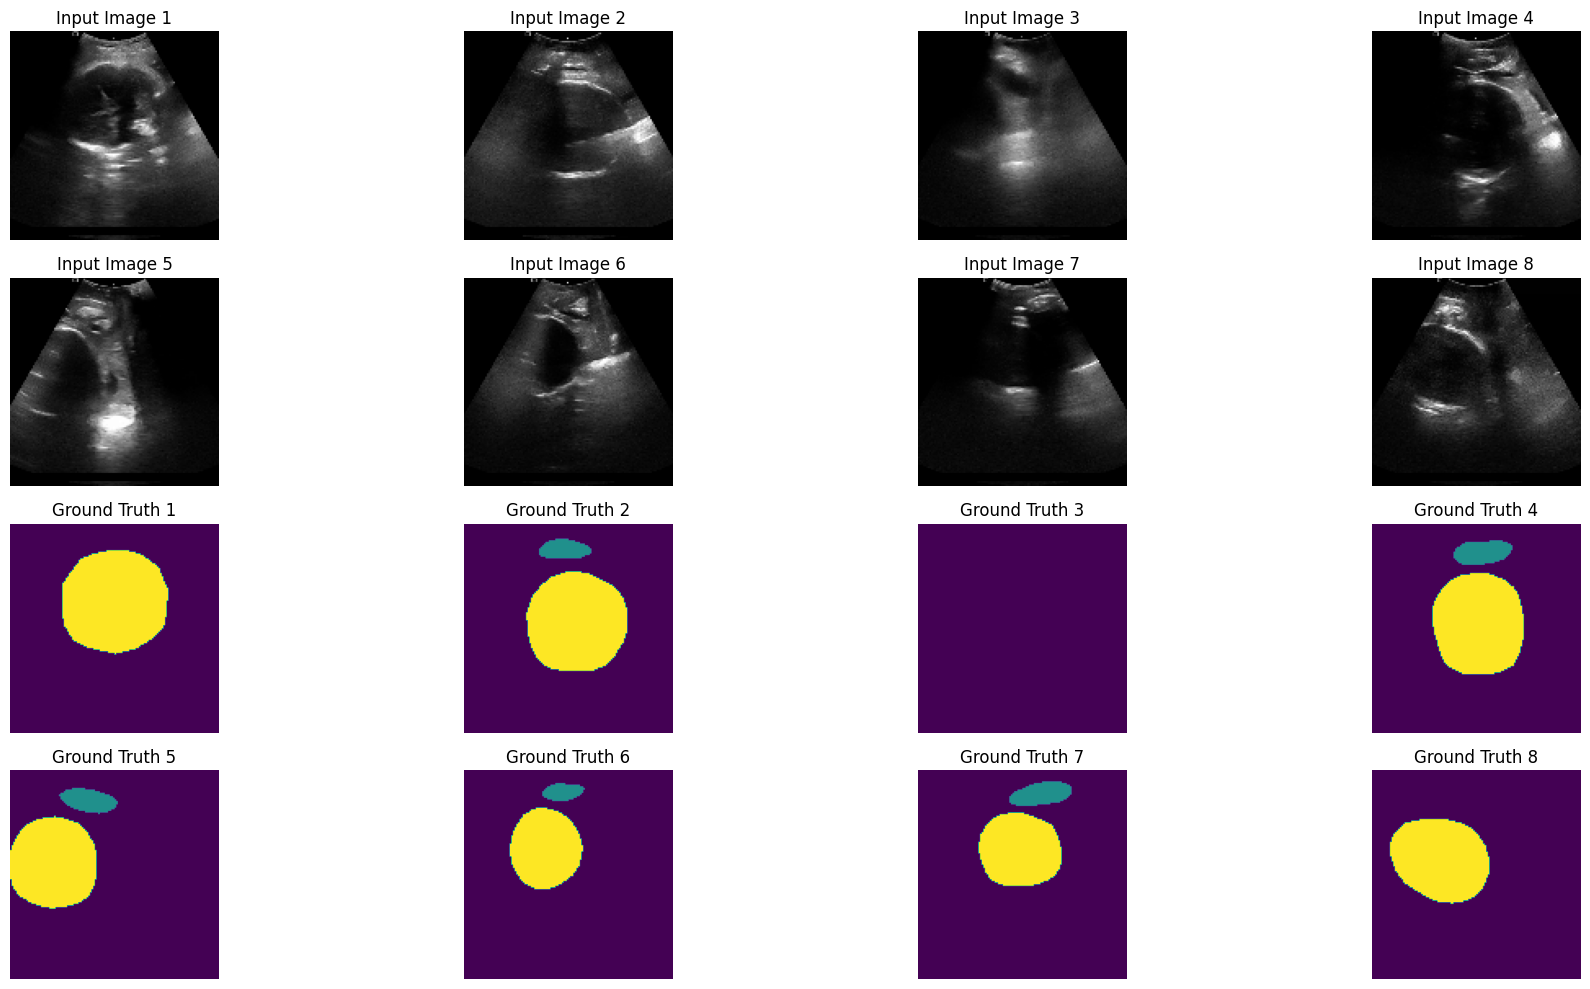

In [6]:
dataset_path = '/kaggle/input/jnu-ifm-for-segment-pubic-symphysis-fetal-head' + '/dataset'
mask_dir = 'mask' # type of mask set: "mask" or "enhance mask"
train_loader, val_loader, test_loader = get_dataset_loaders(dataset_path, mask_dir)

def visualize(loader, n=b_sz):
    # Get a batch of images and masks from the loader
    images, masks = next(iter(loader))

    # Plot the images and masks individually
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))
    axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array

    for i in range(n):
        # Input Image
        axes[i].imshow(images[i].permute(1, 2, 0), cmap='gray')
        axes[i].set_title(f'Input Image {i+1}')
        axes[i].axis('off')  # Hide axis labels and ticks

        # Ground Truth
        axes[i+n].imshow(masks[i].squeeze(), cmap='viridis')
        axes[i+n].set_title(f'Ground Truth {i+1}')
        axes[i+n].axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

visualize(val_loader, b_sz)


# Lightning module

In [7]:
import torchmetrics
from torch.optim import AdamW
from collections import Counter

class TverskyLoss(torch.nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, eps=1e-7):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.eps = eps

    def forward(self, output, target):
        output = F.softmax(output, dim=1)
        target = F.one_hot(target, num_classes=output.shape[1]).permute(0, 3, 1, 2).float()
        
        intersection = torch.sum(output * target, dim=(2, 3))
        fp = torch.sum(output * (1 - target), dim=(2, 3))
        fn = torch.sum((1 - output) * target, dim=(2, 3))
        
        tversky = (intersection + self.eps) / (intersection + self.alpha * fp + self.beta * fn + self.eps)
        loss = 1. - tversky
        return loss.mean()

class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        self.loss = TverskyLoss()
        
        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters(ignore=["model"])

        # Create metrics
        self.train_iou = torchmetrics.JaccardIndex(num_classes=3, average='macro', task='multiclass')
        self.train_acc = torchmetrics.Accuracy(num_classes=3, average='macro', task='multiclass')
        self.train_dice = torchmetrics.Dice(num_classes=3, average='macro')


        self.val_iou = torchmetrics.JaccardIndex(num_classes=3, average='macro', task='multiclass')
        self.val_acc = torchmetrics.Accuracy(num_classes=3, average='macro', task='multiclass')
        self.val_dice = torchmetrics.Dice(num_classes=3, average='macro')


        self.test_iou = torchmetrics.JaccardIndex(num_classes=3, average='macro', task='multiclass')
        self.test_acc = torchmetrics.Accuracy(num_classes=3, average='macro', task='multiclass')
        self.test_dice = torchmetrics.Dice(num_classes=3, average='macro')
        self.test_weighted_iou = torchmetrics.JaccardIndex(num_classes=3, average='weighted', task='multiclass')
        self.test_weighted_acc = torchmetrics.Accuracy(num_classes=3, average='weighted', task='multiclass')
        self.test_weighted_dice = torchmetrics.Dice(average='samples')


    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        
        loss = self.loss(logits, true_labels) # pytorch cross entropy function takes input as logits
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        # Log train accuracy after epoch is completed.
        self.train_acc(predicted_labels, true_labels) 
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        # train iou
        self.train_iou(predicted_labels, true_labels) # Log train accuracy after epoch is completed.
        self.log(
            "train_iou", self.train_iou, prog_bar=True, on_epoch=True, on_step=False
        )
        # train dice
        self.train_dice(predicted_labels, true_labels)
        self.log(
            "train_dice", self.train_dice, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        # Log validation loss
        self.log("val_loss", loss, prog_bar=True)
        # validation accuracy
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True) 
        # validation iou
        self.val_iou(predicted_labels, true_labels)
        self.log("val_iou", self.val_iou, prog_bar=True) 
        # validation iou
        self.val_dice(predicted_labels, true_labels)
        self.log("val_dice", self.val_dice, prog_bar=True) 

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        # intersect over union
        self.test_iou(predicted_labels, true_labels)
        self.log('iou', self.test_iou)
        # accuracy metric
        self.test_acc(predicted_labels, true_labels)
        self.log('accuracy', self.test_acc)
        # dice score/ dice-similarity coefficient (DSC)
        self.test_dice(predicted_labels, true_labels)
        self.log('dice score', self.test_dice)
        
        # weighted verion
        self.test_weighted_iou(predicted_labels, true_labels)
        self.log('weighted iou', self.test_weighted_iou)
        self.test_weighted_acc(predicted_labels, true_labels)
        self.log('weighted accuracy', self.test_weighted_acc)
        self.test_weighted_dice(predicted_labels, true_labels)
        self.log('weighted dice score', self.test_weighted_dice)
        
    
    def configure_optimizers(self):
#         max_lr = 1e-3
#         epoch = 30
#         weight_decay = 1e-4

#         optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
#         sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
#                                                     steps_per_epoch=len(train_loader)
                                                    
        optimizer = AdamW(
            self.model.parameters(), lr=self.learning_rate, weight_decay=1e-4
        )
                                                    
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

# Training

### Model

In [8]:
!pip install -q segmentation-models-pytorch

In [9]:
# Import the library
import segmentation_models_pytorch as smp

## MODEL
pytorch_model = smp.Unet(
    encoder_name="resnet34", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet", # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1, # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3, # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 80.5MB/s]


In [10]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, Callback, EarlyStopping
import time

class CustomeTimingCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        self.start = time.time()
        print("Training is starting")

    def on_train_end(self, trainer, pl_module):
        self.end = time.time()
        total_minutes = (self.end - self.start) / 60
        print(f"Training is ending took {total_minutes} minutes")
        
## Dataloader
dataset_path = '/kaggle/input/jnu-ifm-for-segment-pubic-symphysis-fetal-head' + '/dataset'
mask_dir = 'mask' # type of mask set: "mask" or "enhance mask"
train_loader, val_loader, test_loader = get_dataset_loaders(dataset_path, mask_dir)

## Lightning module
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

## callbacks
callbacks = [
    CustomeTimingCallback(),
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_dice", save_last=True),
#     EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, mode="min"),
]

## Trainer
trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=50,
    accelerator="auto",  # set to "auto" or "gpu" to use GPUs if available
    devices="auto",  # Uses all available GPUs if applicable
    logger=CSVLogger(save_dir="logs/", name="my-model"),
)

trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name               | Type                   | Params
---------------------------------------------------------------
0  | model              | Unet                   | 24.4 M
1  | loss               | TverskyLoss            | 0     
2  | train_iou          | MulticlassJaccardIndex | 0     
3  | train_acc          | MulticlassAccuracy     | 0     
4  | train_dice         | Dice                   | 0     
5  | val_iou            | MulticlassJaccardIndex | 0     
6  | val_acc            | MulticlassAccuracy     | 0     
7  | val_dice           | Dice                   | 0     
8  | test_iou           | MulticlassJaccardIndex | 0     
9  | test_acc           | MulticlassAccuracy     | 0     
10 | test_dice          | Dice                   | 0     
11 | test

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training is starting


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


Training is ending took 38.821643606821695 minutes


# Testing and evaluation

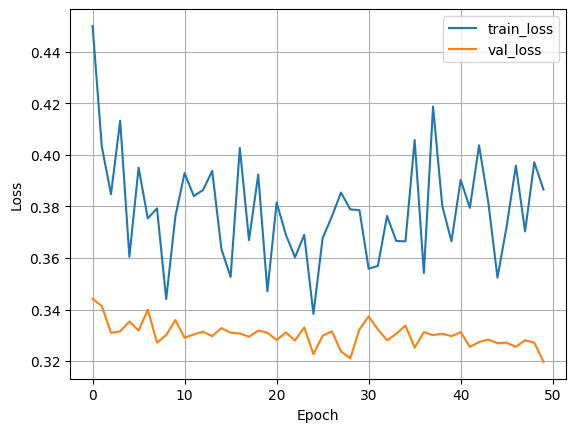

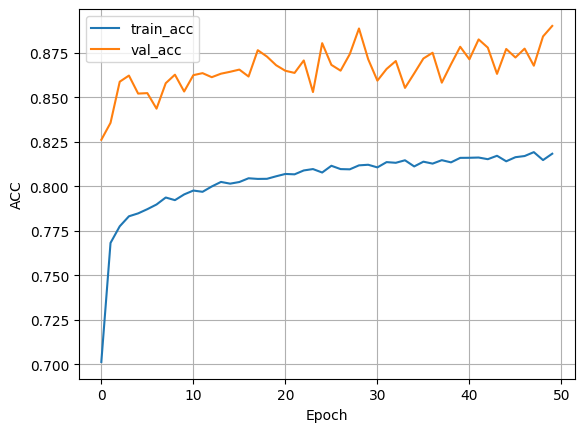

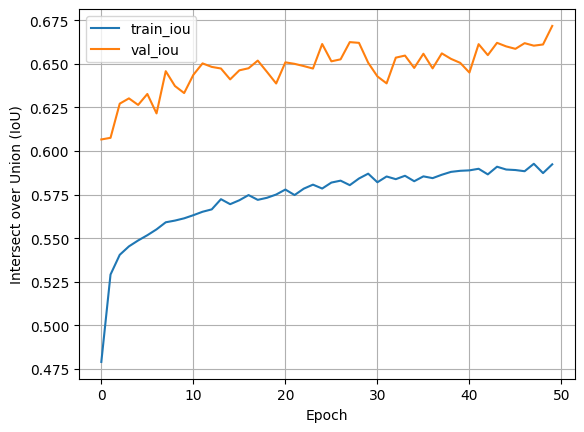

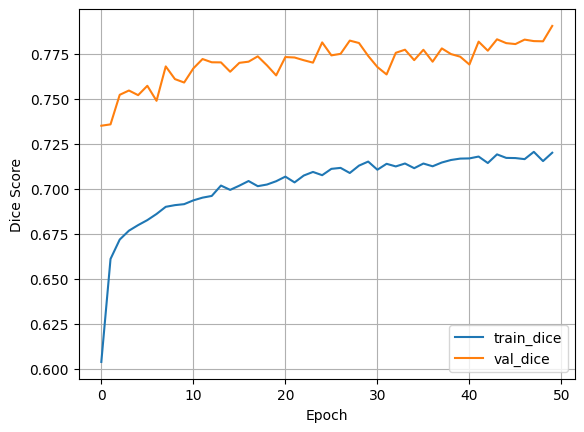

In [11]:
import pandas as pd
import matplotlib.pyplot as plt


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)
    
df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

df_metrics[["train_iou", "val_iou"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Intersect over Union (IoU)"
)

df_metrics[["train_dice", "val_dice"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Dice Score"
)

plt.show()

In [12]:
# Evaluate model based on test_step
print(trainer.test(dataloaders=test_loader, ckpt_path="best"))
print(trainer.test(dataloaders=test_loader, ckpt_path="last"))

INFO: Restoring states from the checkpoint path at logs/my-model/version_0/checkpoints/epoch=49-step=31500.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at logs/my-model/version_0/checkpoints/epoch=49-step=31500.ckpt
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.8923546075820923     │
│        dice score         │    0.7904732823371887     │
│            iou            │    0.6716868877410889     │
│     weighted accuracy     │    0.9189978241920471     │
│    weighted dice score    │    0.9189978837966919     │
│       weighted iou        │    0.8647809624671936     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /kaggle/working/logs/my-model/version_0/checkpoints/last.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /kaggle/working/logs/my-model/version_0/checkpoints/last.ckpt


[{'iou': 0.6716868877410889, 'accuracy': 0.8923546075820923, 'dice score': 0.7904732823371887, 'weighted iou': 0.8647809624671936, 'weighted accuracy': 0.9189978241920471, 'weighted dice score': 0.9189978837966919}]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.8923546075820923     │
│        dice score         │    0.7904732823371887     │
│            iou            │    0.6716868877410889     │
│     weighted accuracy     │    0.9189978241920471     │
│    weighted dice score    │    0.9189978837966919     │
│       weighted iou        │    0.8647809624671936     │
└───────────────────────────┴───────────────────────────┘

[{'iou': 0.6716868877410889, 'accuracy': 0.8923546075820923, 'dice score': 0.7904732823371887, 'weighted iou': 0.8647809624671936, 'weighted accuracy': 0.9189978241920471, 'weighted dice score': 0.9189978837966919}]


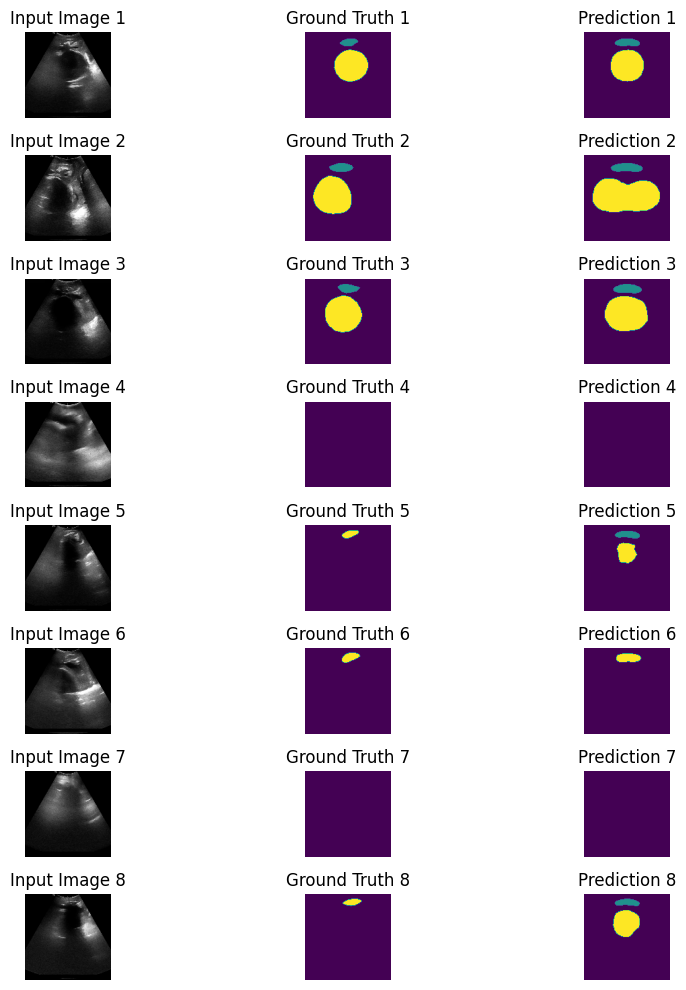

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def visualize_full(loader, model):
    # Get a batch of images and masks from the loader
    images, masks = next(iter(loader))
    images, masks = images.to(device), masks.to(device)
    model.to(device)
    
    # Get model predictions
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        preds = model(images)

    batch_size = images.size(0)

    # Plot the images, masks, and predictions individually
    fig, axes = plt.subplots(nrows=batch_size, ncols=3, figsize=(10, 10))  # Adjust the number of rows and columns here
    axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array

    for i in range(batch_size):
        # Input Image
        axes[3*i].imshow(images[i].cpu().permute(1, 2, 0), cmap='gray')
        axes[3*i].set_title(f'Input Image {i+1}')
        axes[3*i].axis('off')  # Hide axis labels and ticks

        # Ground Truth
        axes[3*i+1].imshow(masks[i].cpu().squeeze(), cmap='viridis')
        axes[3*i+1].set_title(f'Ground Truth {i+1}')
        axes[3*i+1].axis('off')

        # Model Prediction
        axes[3*i+2].imshow(torch.argmax(preds[i], dim=0).cpu().squeeze(), cmap='viridis')
        axes[3*i+2].set_title(f'Prediction {i+1}')
        axes[3*i+2].axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

visualize_full(test_loader, pytorch_model)